In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
%config InlineBackend.figure_format = 'svg'

## Getting toy data

In [3]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 200
n_classes = 2
samples_per_class = n_samples // n_classes

# Generate categorical features as numeric values
categories_1 = np.random.choice([0, 1, 2], size=n_samples)  # Encoding A, B, C as 0, 1, 2
categories_2 = np.random.choice([0, 1], size=n_samples)  # Encoding X, Y as 0, 1

# Generate continuous features
# Feature 1: Unimodal normal distribution
feature_1 = np.random.normal(loc=50, scale=10, size=n_samples)

# Feature 2 & 3: Bimodal normal distributions
feature_2 = np.hstack((
    np.random.normal(loc=30, scale=5, size=samples_per_class),
    np.random.normal(loc=60, scale=5, size=samples_per_class)
))
feature_3 = np.hstack((
    np.random.normal(loc=20, scale=7, size=samples_per_class),
    np.random.normal(loc=70, scale=7, size=samples_per_class)
))

# Generate class labels
labels = np.array([0] * samples_per_class + [1] * samples_per_class)

# Shuffle the dataset
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Create DataFrame
data = pd.DataFrame({
    'Categorical_1': categories_1[indices],
    'Categorical_2': categories_2[indices],
    'Feature_1': feature_1[indices],
    'Feature_2': feature_2[indices],
    'Feature_3': feature_3[indices],
    'Label': labels[indices]
})

In [4]:
data.columns

Index(['Categorical_1', 'Categorical_2', 'Feature_1', 'Feature_2', 'Feature_3',
       'Label'],
      dtype='object')

In [5]:
continuous_features=[]
categorical_features=[]
for column in data.columns:
    if data[column].dtype=='int32' or data[column].dtype=='int4':
        categorical_features.append(column)
    else:
        continuous_features.append(column)

In [6]:
continuous_features

['Feature_1', 'Feature_2', 'Feature_3']

In [7]:
categorical_features

['Categorical_1', 'Categorical_2', 'Label']

In [8]:
for feature in data.columns:
    if feature in continuous_features:
        data[feature]=(data[feature]-data[feature].min())/(data[feature].max()-data[feature].min())

In [9]:
data

,Categorical_1,Categorical_2,Feature_1,Feature_2,Feature_3,Label
0,0,1,0.386189,0.766002,0.895039,1
1,2,1,0.438744,0.177973,0.355032,0
2,1,0,0.412323,0.234305,0.140200,0
3,1,0,0.358023,0.420836,0.273019,0
4,0,0,0.503796,0.804338,0.822876,1
...,...,...,...,...,...,...
195,2,1,0.222909,0.271268,0.248421,0
196,2,1,0.218812,0.786598,0.865701,1
197,0,1,0.000000,0.846724,0.812180,1
198,1,0,0.532863,0.836881,0.879920,1


## Vizualizing feature-wise distributions

In [10]:
def get_bin_and_counts(feature_name):
    bins=np.linspace(data[feature_name].min(),data[feature_name].max(),20)
    bins,counts=np.unique(np.digitize(data[feature_name],bins),return_counts=True)
    return bins,counts/np.sum(counts)

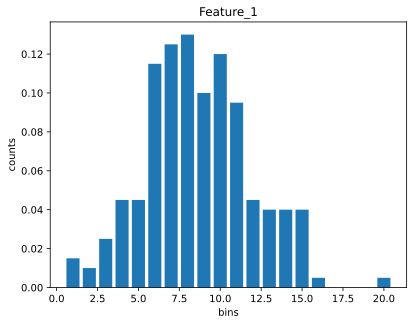

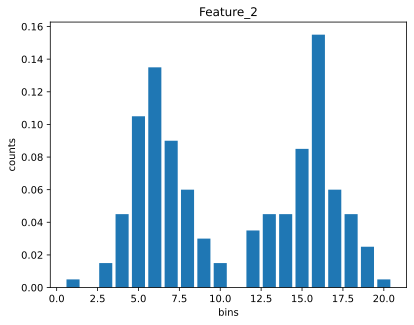

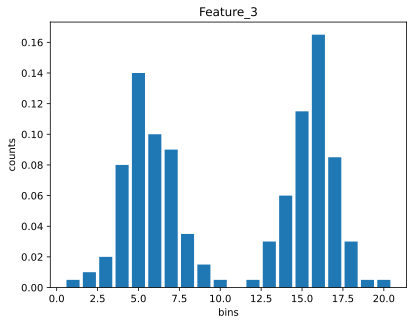

In [11]:
for feature_name in continuous_features:
    bins,counts=get_bin_and_counts(feature_name)
    plt.bar(bins, counts)
    plt.title(feature_name)
    plt.xlabel('bins')
    plt.ylabel('counts')
    plt.show()

In [12]:
def get_gaussian_likelihood(x,mu,sigma):
    constant=1/(np.sqrt(2*np.pi)*sigma)
    term=np.exp(-(1/2)*((x-mu)/sigma)**2)
    return constant*term

In [13]:
def get_likeloood_KDE(x, dataset, feature_name, bandwidth=0.04):
    s=0
    for i in range(len(dataset)):
        s=s+get_gaussian_likelihood(x,dataset[feature_name][i],bandwidth)
    likelihood=s/len(dataset)
    return likelihood

## Vizualization of likehoods over entire dataset: KDE vs Gaussian

In [14]:
def get_grid(feature, num_points=300):
    return np.linspace(data[feature].min(),data[feature].max(),num_points)

In [15]:
def vizualize_likelihoods_kde_vs_gaussian(feature):
    KDE_likelihoods_over_a_feature=[]
    grid=np.linspace(data[feature].min(),data[feature].max(),300)
    for i in range(len(grid)):
        likelihood=get_likeloood_KDE(grid[i],data,feature)
        KDE_likelihoods_over_a_feature.append(likelihood)

    gaussian_likelihoods_over_a_feature=[]
    for i in range(len(grid)):
        likelihood=get_gaussian_likelihood(grid[i],data[feature].mean(),data[feature].std())
        gaussian_likelihoods_over_a_feature.append(likelihood)
    return KDE_likelihoods_over_a_feature, gaussian_likelihoods_over_a_feature

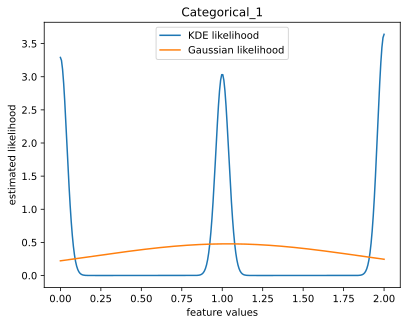

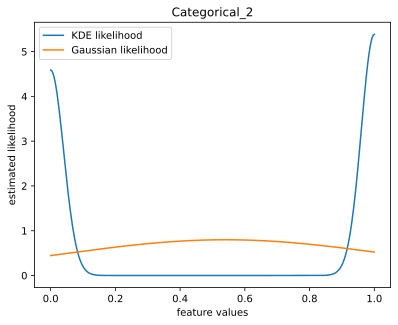

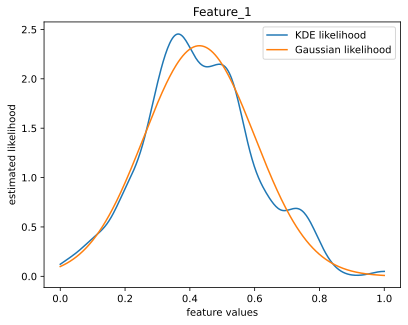

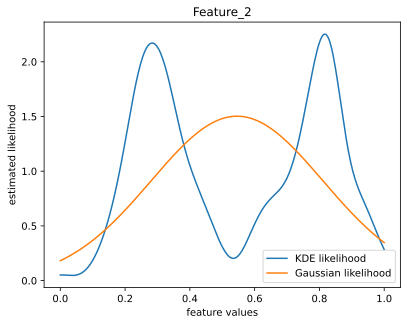

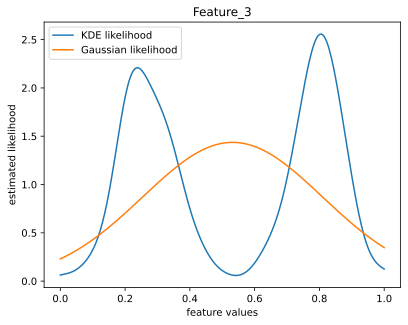

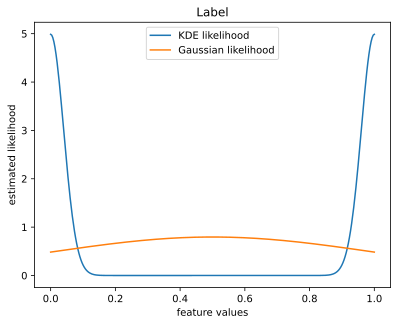

In [16]:
for feature in data.columns:
    grid= get_grid(feature)
    KDE_likelihoods_over_a_feature, gaussian_likelihoods_over_a_feature=vizualize_likelihoods_kde_vs_gaussian(feature)
    plt.plot(grid,KDE_likelihoods_over_a_feature,label='KDE likelihood')
    plt.plot(grid,gaussian_likelihoods_over_a_feature,label='Gaussian likelihood')
    plt.xlabel('feature values')
    plt.ylabel('estimated likelihood')
    plt.legend()
    plt.title(feature)
    plt.show()

## Vizualization of likehoods over entire data restricted class-wise 

In [17]:
def get_likeloood_KDE_class_wise(x, dataset, class_label, feature_name, bandwidth=0.04):
    data_class=dataset.loc[dataset['Label']==class_label]
    s=0
    for i in range(len(data_class)):
        s=s+get_gaussian_likelihood(x,list(data_class[feature_name])[i],bandwidth)
    likelihood=s/len(data_class)
    return likelihood

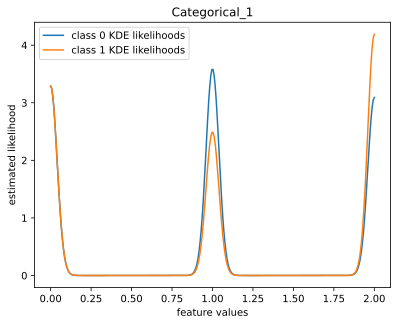

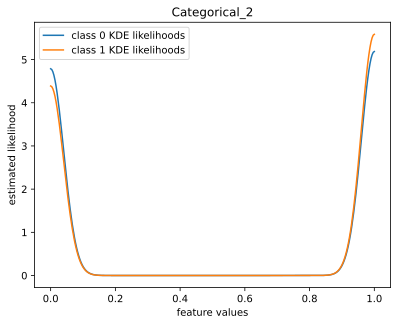

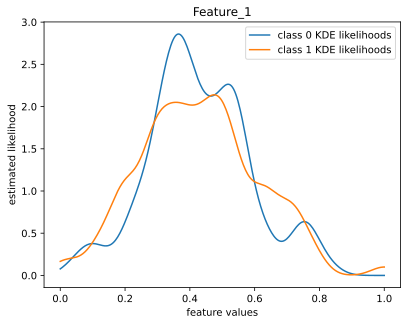

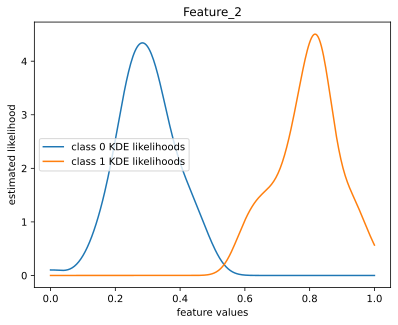

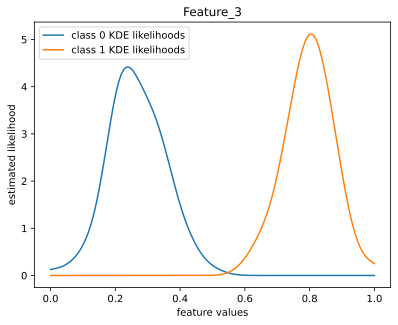

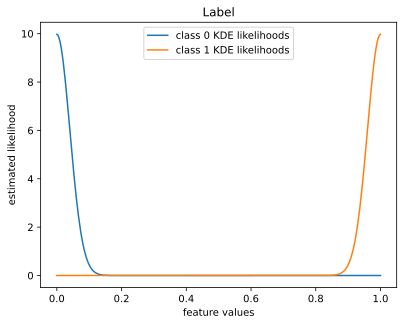

In [18]:
for feature in data.columns:
    grid=np.linspace(data[feature].min(),data[feature].max(),300)
    
    likelihood_class_0=[]
    for i in range(len(grid)):
        likelihood=get_likeloood_KDE_class_wise(grid[i], data, 0, feature, bandwidth=0.04)
        likelihood_class_0.append(likelihood)
        
    likelihood_class_1=[]
    for i in range(len(grid)):
        likelihood=get_likeloood_KDE_class_wise(grid[i], data, 1, feature, bandwidth=0.04)
        likelihood_class_1.append(likelihood)
        
    plt.plot(grid,likelihood_class_0, label='class 0 KDE likelihoods')
    plt.plot(grid,likelihood_class_1, label='class 1 KDE likelihoods')
    plt.xlabel('feature values')
    plt.ylabel('estimated likelihood')
    plt.title(feature)
    plt.legend()
    plt.show()
    

## Dividing the data into train and test sets and using a KDE-assisted Naive Bayes Classifier

In [19]:
data=data.sample(frac=1,random_state=1)

In [20]:
data=data.reset_index(drop=True)

In [21]:
data_train=data.iloc[:150]

In [22]:
data_test=data.iloc[150:]

In [23]:
def get_likeloood_KDE_class_wise_train(x, data_train, class_label, feature_name, bandwidth=0.04):
    data_class=data_train.loc[data_train['Label']==class_label]
    s=0
    for i in range(len(data_class)):
        s=s+get_gaussian_likelihood(x,list(data_class[feature_name])[i],bandwidth)
    likelihood=s/len(data_class)
    return likelihood

In [24]:
def get_feature_wise_likelihood(data_train,data_test_index,target):
    p=1
    for feature in data.columns[:-1]:
        l=get_likeloood_KDE_class_wise_train(data_test.iloc[data_test_index][feature], data_train, target, feature, bandwidth=0.04)
        p=p*l
    return p

In [25]:
priors_ones=data_train['Label'].value_counts()[1]/len(data_train)

In [26]:
priors_zeroes=data_train['Label'].value_counts()[0]/len(data_train)

In [27]:
calculate_test_likelihoods=[]
for i in range(len(data_test)):
    class_0_likelihood=get_feature_wise_likelihood(data_train,i,0)*priors_zeroes
    class_1_likelihood=get_feature_wise_likelihood(data_train,i,1)*priors_ones
    calculate_test_likelihoods.append([class_0_likelihood,class_1_likelihood])

In [28]:
y_pred=np.argmax(np.array(calculate_test_likelihoods),axis=1)

In [29]:
y_test=np.array(data_test['Label'])

In [30]:
print('Accuracy of the model is '+ str(sum(y_test==y_pred)/len(data_test)*100)+' percent')

Accuracy of the model is 100.0 percent
